# InterpretE experiments with FB15K-237

In [157]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV , train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import cohen_kappa_score, make_scorer
import numpy as np
import pandas as pd
from tqdm import tqdm
from copy import deepcopy
import torch
from kge.util.io import load_checkpoint

## Load entities with their embeddings

In [158]:
# Load entity type Dataframe
entities_df = pd.read_csv('data/entities_types.csv', sep=',', header=0)


#load YAGO Embedding
checkpoint = load_checkpoint('../embeddings/fb15k-237-complex.pt') # Change the path of the model here
model = checkpoint["model"]
tensor_embed: torch.Tensor = dict(checkpoint['model'][0])['_entity_embedder.embeddings.weight']
all_arrays = tensor_embed.numpy()

Loading Embeddings...


## Load dataset

In [159]:
# Load dataset to get the relations
print("Loading triples...")
cols_name = ["head", "relation", "tail"]
NAME_SUBGRAPH = ["train", "test", "valid"]
triples_df = pd.concat(
    (pd.read_csv(
        "data/" + f + '.csv',
        sep="\t",
        names=cols_name) for f in NAME_SUBGRAPH),
    ignore_index=True)
# Get distinct relations
distinct_relations = triples_df["relation"].unique()

Loading triples...


In [160]:
# Dictionnary for all the boolean value of relation regarding entitiy
value_relations = {relation: set() for relation in distinct_relations}

print("Check if the relations exists...")
for _, row in triples_df.iterrows():
    # Extract entity and relations
    head = row["head"]
    relation = row["relation"]
    # Add the entity to the corresponding set
    value_relations[relation].add(head)

Check if the relations exists...


In [161]:
print("Generate a global DataFrame with all the data...")
# Convert the sets into a boolean lists
value_relations = {relation: [entity in value_relations[relation]
                              for entity in entities_df["Entity"]] for relation in distinct_relations}
# Convert to a Pandas Dataframe
relations_df = pd.DataFrame(value_relations)
global_df = pd.concat((entities_df, relations_df), axis=1)

Generate a global DataFrame with all the data...


## Utils

In [162]:
# defining parameter range ofr GridSearch
# Define the hyperparameter grid
param_grid = [
  {'C': [0.1, 1, 2.5, 5, 7.5, 10], 'kernel': ['rbf']},
 ]

In [163]:
def similarity_score(ref, neighbours, df_with_labels, mode: str = "one"):
    # Determine the label of the reference
    label_ref = df_with_labels[df_with_labels['Entity']== ref]['labels'].to_list()[0]
    
    # Determine labels for all neighbors at once
    all_neighbours_labels = np.array([df_with_labels[df_with_labels['Entity'] == name]['labels'].to_list()[0] for name in neighbours])

    # Calculate intersection scores

    if mode == "one":
        intersect_labels = np.logical_and(label_ref, all_neighbours_labels)
        # Sum the intersect labels along axis 1 (columns) and count non-zero elements
        non_zero = np.count_nonzero(intersect_labels, axis=1)

        # Count number of rows with non-zero elements
        score = np.count_nonzero(non_zero)
    elif mode == "all":
        all_each_line = np.all(all_neighbours_labels == label_ref, axis=1)
        # Count number of rows with non-zero elements
        score = np.count_nonzero(all_each_line)
    else:
        raise ValueError("This is not a valid mode.")

    return score / len(neighbours)

def closest_neighbours(ref_entity, other_entities, df_with_labels, k, mode: str = "euclidean"):
    if mode == "euclidean":
        relative_ref = other_entities - ref_entity
        dist_to_ref = np.linalg.norm(relative_ref, axis=1)
        k_closest_entity = np.argsort(dist_to_ref)[1:(k+1)]
        return df_with_labels['Entity'].iloc[k_closest_entity]
    elif mode == "cosine":
        norm_ref = np.linalg.norm(ref_entity)
        ref_norm = ref_entity / norm_ref
        norm_other = np.linalg.norm(other_entities, axis=1)
        normalized_other = np.divide(other_entities, norm_other.reshape(-1,1)) # division elementwise
        cosine_sim = normalized_other.dot(ref_norm.T).reshape(-1,)
        # We take the k elemnt with the highest score
        k_closest_values = np.argsort(cosine_sim)[-(k+1):-1]
        return df_with_labels['Entity'].iloc[k_closest_values]
    raise ValueError("This is not a valid mode of similarity")

## SVM Person gender and nationality

In [164]:
# Loads all the data related to humans
entity_type = "person_100007846"

triples_gender = triples_df[(triples_df['relation'] == 'gender')]
gender_head = set(triples_gender['head'].to_list())

triples_nationality = triples_df[(triples_df['relation'] == 'nationality')]
nationality_head = set(triples_nationality["head"].to_list())


human_head = entities_df[entities_df['Entity'].isin(gender_head) & entities_df["type"].apply(lambda x: entity_type in x) & entities_df['Entity'].isin(nationality_head)]
human_index = np.array(human_head.index, dtype=int)

In [165]:
# Scale embeddings only to concerned data
scale_human_data = deepcopy(all_arrays)
scale = StandardScaler()
scale_human_data[human_index] = scale.fit_transform(scale_human_data[human_index])

In [166]:
top_nationalities = ["United States of America", "England", "United Kingdom", "India", "Canada"]
SVC_human: list[GridSearchCV] = [GridSearchCV(SVC(class_weight='balanced'), param_grid, refit = True, verbose = 1, scoring = make_scorer(cohen_kappa_score), n_jobs=-1)]*(len(top_nationalities)+1)

### Label data

In [167]:
labels_globals = [np.array([nationality in set(triples_nationality[triples_nationality['head'] == human]['tail'].to_list()) for human in entities_df['Entity'][human_index]]) for nationality in tqdm(top_nationalities)]

100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


In [168]:
labels_gender = np.array([triples_gender[triples_gender['head'] == human]['tail'].to_list()[0] == 'male organism' for human in entities_df['Entity'][human_index]])

In [169]:
labels_globals.append(labels_gender)

### Train SVM

In [170]:
decision_human = []
for idx, svm in enumerate(SVC_human):
    # We split the entities
    X_human_train, X_human_test, y_human_train, y_human_test  = train_test_split(scale_human_data[human_index], labels_globals[idx], test_size=0.2, random_state=42)
    svm.fit(X_human_train, y_human_train)
    print("The training accuracy is: {:.2f} %".format(svm.score(X_human_train, y_human_train)*100))
    print("The testing accuracy is: {:.2f} %".format(svm.score(X_human_test, y_human_test)*100))
    print("The testing kappa score is {:.2f}".format(cohen_kappa_score(svm.predict(X_human_test), y_human_test)))
    print("The best parameters are", svm.best_params_)
    decision_human.append(svm.best_estimator_.decision_function(scale_human_data).reshape(-1, 1))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
The training accuracy is: 99.87 %
The testing accuracy is: 91.10 %
The testing kappa score is 0.91
The best parameters are {'C': 5, 'kernel': 'rbf'}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
The training accuracy is: 90.23 %
The testing accuracy is: 76.92 %
The testing kappa score is 0.77
The best parameters are {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
The training accuracy is: 83.72 %
The testing accuracy is: 56.55 %
The testing kappa score is 0.57
The best parameters are {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
The training accuracy is: 99.40 %
The testing accuracy is: 98.45 %
The testing kappa score is 0.98
The best parameters are {'C': 0.1, 'kernel': 'rbf'}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
The training accuracy is: 93.65 %
The testing accuracy is: 85.86 %
The testing kappa score is 0.86
The

### Project into the 2d space

In [171]:
# Project and add bias through decision function
human_proj = np.concatenate(decision_human, axis=1)

### Evaluation

In [172]:
# Add a new column with all labels
labels_globals = np.array(labels_globals).T
human_head["labels"] = labels_globals.tolist()

/tmp/ipykernel_27685/1674643406.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_head["labels"] = labels_globals.tolist()


In [174]:
male_not_US = np.intersect1d(np.where(labels_globals[:, 0] == False), np.where(labels_globals[:, -1] == True))
female_not_US = np.intersect1d(np.where(labels_globals[:, 0] == False), np.where(labels_globals[:, -1] == False))
male_US = np.intersect1d(np.where(labels_globals[:, 0] == True), np.where(labels_globals[:, -1] == True))
female_US = np.intersect1d(np.where(labels_globals[:, 0] == True), np.where(labels_globals[:, -1] == False))


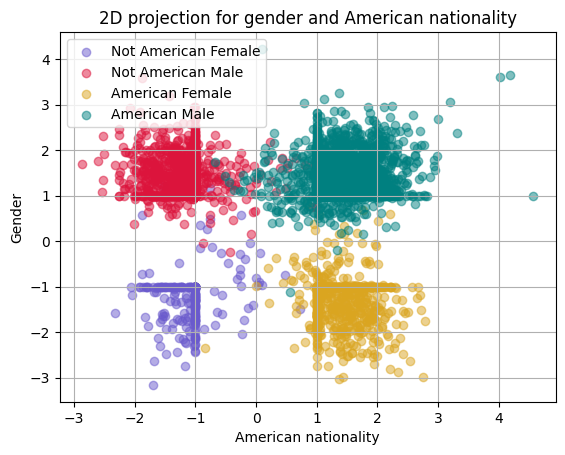

In [175]:
import matplotlib.pyplot as plt

observed_human_proj = human_proj[:, [0, -1]]

X, Y = observed_human_proj[human_index,0], observed_human_proj[human_index,1]

plt.scatter(X[female_not_US], Y[female_not_US], label='Not American Female', color='slateblue', alpha=0.5)

plt.scatter(X[male_not_US], Y[male_not_US], label='Not American Male', color="crimson", alpha=0.5)

plt.scatter(X[female_US], Y[female_US], label='American Female', color="goldenrod", alpha=0.5)

plt.scatter(X[male_US], Y[male_US], label='American Male', color='teal', alpha=0.5)

plt.title('2D projection for gender and American nationality')
plt.xlabel("American nationality")
plt.ylabel("Gender")
plt.grid()
plt.legend()
plt.show()

### Neighbourhood similarity

In [176]:
# Global similarity score
k=10
scores_raw = 0
scores_proj = 0
for idx in tqdm(human_index):
    # Choose a ref
    ref_proj = human_proj[idx,:]
    ref_name = human_head['Entity'][idx]
    # Before projection
    ref_entity = scale_human_data[idx,:]
    closest_entity_raw = closest_neighbours(ref_entity, scale_human_data[human_index], human_head, k)
    scores_raw += similarity_score(ref_name, closest_entity_raw, human_head, mode="all")

    # After projection
    closest_entity = closest_neighbours(ref_proj, human_proj[human_index], human_head, k)
    scores_proj += similarity_score(ref_name, closest_entity, human_head, mode="all")

scores_raw /= len(human_index)
scores_proj /= len(human_index)

100%|██████████| 4343/4343 [01:21<00:00, 53.03it/s]


In [177]:
print(f"The similarity score before projection of the top{k} entity is: {round(scores_raw,3)}")
print(f"The similarity score after projection of the top{k} entity is: {round(scores_proj,3)}")

The similarity score before projection of the top10 entity is: 0.563
The similarity score after projection of the top10 entity is: 0.932


## SVM on Organizations and relation citytown

In [178]:
# Loads all the data related to humans
entity_type = "organization_108008335"

triples_organization_location = triples_df[(triples_df['relation'] == 'citytown')]
organization_head = set(triples_organization_location['head'].to_list())


organization_head = entities_df[entities_df['Entity'].isin(organization_head) & entities_df["type"].apply(lambda x: entity_type in x)]
organization_index = np.array(organization_head.index, dtype=int)

In [179]:
LOCATIONS_PATH = "data/map_location_country.csv"
all_locations = pd.read_csv(LOCATIONS_PATH, sep=",", header=0, names=["cities", "countries"])

dict_locations = dict(all_locations.values)

In [180]:
# Scale embeddings only to concerned data
scale_organization_data = deepcopy(all_arrays)
scale = StandardScaler()
scale_organization_data[organization_index] = scale.fit_transform(scale_organization_data[organization_index])

In [181]:
top_locations = ["United States", "United Kingdom", "Japan", "Canada", "Germany"]
SVC_organization: list[GridSearchCV] = [GridSearchCV(SVC(class_weight='balanced'), param_grid, refit = True, verbose = 1, scoring = make_scorer(cohen_kappa_score), n_jobs=-1)]*len(top_locations)

In [182]:
def isInCountry(location, country_ref):
    if location in dict_locations.keys():
        country = dict_locations[location]
        return country == country_ref
    return False

labels_organization = [np.array([isInCountry(triples_organization_location[triples_organization_location['head'] == organization]['tail'].to_list()[0], location) for organization in entities_df['Entity'][organization_index]]) for location in tqdm(top_locations)]

100%|██████████| 5/5 [00:01<00:00,  4.32it/s]


In [183]:
decision_organization = []
for idx, svm in enumerate(SVC_organization):
    # We split the entities
    X_organization_train, X_organization_test, y_organization_train, y_organization_test  = train_test_split(scale_organization_data[organization_index], labels_organization[idx], test_size=0.2, random_state=42)
    svm.fit(X_organization_train, y_organization_train)
    print("The training accuracy is: {:.2f} %".format(svm.score(X_organization_train, y_organization_train)*100))
    print("The testing accuracy is: {:.2f} %".format(svm.score(X_organization_test, y_organization_test)*100))
    print("The testing kappa score is {:.2f}".format(cohen_kappa_score(svm.predict(X_organization_test), y_organization_test)))
    print("The best parameters are", svm.best_params_)
    decision_organization.append(svm.best_estimator_.decision_function(scale_organization_data).reshape(-1, 1))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
The training accuracy is: 100.00 %
The testing accuracy is: 87.93 %
The testing kappa score is 0.88
The best parameters are {'C': 5, 'kernel': 'rbf'}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
The training accuracy is: 97.90 %
The testing accuracy is: 89.22 %
The testing kappa score is 0.89
The best parameters are {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
The training accuracy is: 100.00 %
The testing accuracy is: 90.57 %
The testing kappa score is 0.91
The best parameters are {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
The training accuracy is: 87.95 %
The testing accuracy is: 71.71 %
The testing kappa score is 0.72
The best parameters are {'C': 0.1, 'kernel': 'rbf'}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
The training accuracy is: 100.00 %
The testing accuracy is: 56.32 %
The testing kappa score is 0.56


### Projection into the new space

In [184]:
# Project and add bias through decision function
organization_proj = np.concatenate(decision_organization, axis=1)

## Evaluation

In [185]:
# Add a new column with all labels
labels_organization = np.array(labels_organization).T
organization_head["labels"] = labels_organization.tolist()

/tmp/ipykernel_27685/548220679.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  organization_head["labels"] = labels_organization.tolist()


### Neighbourhood similarity

In [187]:
# Global similarity score
k=10
scores_raw = 0
scores_proj = 0
for idx in tqdm(organization_index):
    # Choose a ref
    ref_proj = organization_proj[idx,:]
    ref_name = organization_head['Entity'][idx]
    # Before projection
    ref_entity = scale_organization_data[idx,:]
    closest_entity_raw = closest_neighbours(ref_entity, scale_organization_data[organization_index], organization_head, k)
    scores_raw += similarity_score(ref_name, closest_entity_raw, organization_head, mode="all")

    # After projection
    closest_entity = closest_neighbours(ref_proj, organization_proj[organization_index], organization_head, k)
    scores_proj += similarity_score(ref_name, closest_entity, organization_head, mode="all")

scores_raw /= len(organization_index)
scores_proj /= len(organization_index)

100%|██████████| 758/758 [00:05<00:00, 129.20it/s]


In [188]:
print(f"The similarity score before projection of the top{k} entity is: {round(scores_raw,3)}")
print(f"The similarity score after projection of the top{k} entity is: {round(scores_proj,3)}")

The similarity score before projection of the top10 entity is: 0.768
The similarity score after projection of the top10 entity is: 0.96


### SVM on film_release_region

In [189]:
# Loads all the data related to movies
entity_type = "movie_106613686"

triples_film_region = triples_df[(triples_df['relation'] == 'film_release_region')]
film_region_head = set(triples_film_region['head'].to_list())


film_region_head = entities_df[entities_df['Entity'].isin(film_region_head) & entities_df["type"].apply(lambda x: entity_type in x)]
film_region_index = np.array(film_region_head.index, dtype=int)

In [190]:
# Scale embeddings only to concerned data
scale_film_region_data = deepcopy(all_arrays)
scale = StandardScaler()
scale_film_region_data[film_region_index] = scale.fit_transform(scale_film_region_data[film_region_index])

In [191]:
top_regions = ["United States of America", "Sweden", "France", "Spain", "Finland"]
SVC_film_region: list[GridSearchCV] = [GridSearchCV(SVC(class_weight='balanced'), param_grid, refit = True, verbose = 1, scoring = make_scorer(cohen_kappa_score), n_jobs=-1)]*len(top_regions)

### Label data

In [192]:
labels_film_region = [np.array([region in triples_film_region[triples_film_region['head'] == film]['tail'].to_list() for film in entities_df['Entity'][film_region_index]]) for region in tqdm(top_regions)]

100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


### Train SVM

In [193]:
decision_film_region = []
for idx, svm in enumerate(SVC_film_region):
    # We split the entities
    X_film_region_train, X_film_region_test, y_film_region_train, y_film_region_test  = train_test_split(scale_film_region_data[film_region_index], labels_film_region[idx], test_size=0.2, random_state=42)
    svm.fit(X_film_region_train, y_film_region_train)
    print("The training accuracy is: {:.2f} %".format(svm.score(X_film_region_train, y_film_region_train)*100))
    print("The testing accuracy is: {:.2f} %".format(svm.score(X_film_region_test, y_film_region_test)*100))
    print("The testing kappa score is {:.2f}".format(cohen_kappa_score(svm.predict(X_film_region_test), y_film_region_test)))
    print("The best parameters are", svm.best_params_)
    decision_film_region.append(svm.best_estimator_.decision_function(scale_film_region_data).reshape(-1, 1))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
The training accuracy is: 99.17 %
The testing accuracy is: 7.37 %
The testing kappa score is 0.07
The best parameters are {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
The training accuracy is: 96.62 %
The testing accuracy is: 88.47 %
The testing kappa score is 0.88
The best parameters are {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
The training accuracy is: 94.62 %
The testing accuracy is: 87.64 %
The testing kappa score is 0.88
The best parameters are {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
The training accuracy is: 93.07 %
The testing accuracy is: 86.25 %
The testing kappa score is 0.86
The best parameters are {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
The training accuracy is: 98.75 %
The testing accuracy is: 85.21 %
The testing kappa score is 0.85
The be

### Projection into the new space

In [194]:
# Project and add bias through decision function
film_region_proj = np.concatenate(decision_film_region, axis=1)

### Evaluation

In [195]:
# Add a new column with all labels
labels_film_region = np.array(labels_film_region).T
film_region_head["labels"] = labels_film_region.tolist()

/tmp/ipykernel_27685/3989658225.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  film_region_head["labels"] = labels_film_region.tolist()


### Neighbourhood similarity

In [197]:
# Global similarity score
k=10
scores_raw = 0
scores_proj = 0
for idx in tqdm(film_region_index):
    # Choose a ref
    ref_proj = film_region_proj[idx,:]
    ref_name = film_region_head['Entity'][idx]
    # Before projection
    ref_entity = scale_film_region_data[idx,:]
    closest_entity_raw = closest_neighbours(ref_entity, scale_film_region_data[film_region_index], film_region_head, k)
    scores_raw += similarity_score(ref_name, closest_entity_raw, film_region_head, mode="all")

    # After projection
    closest_entity = closest_neighbours(ref_proj, film_region_proj[film_region_index], film_region_head, k)
    scores_proj += similarity_score(ref_name, closest_entity, film_region_head, mode="all")

scores_raw /= len(film_region_index)
scores_proj /= len(film_region_index)

100%|██████████| 1204/1204 [00:11<00:00, 103.07it/s]


In [198]:
print(f"The similarity score before projection of the top{k} entity is: {round(scores_raw,3)}")
print(f"The similarity score after projection of the top{k} entity is: {round(scores_proj,3)}")

The similarity score before projection of the top10 entity is: 0.661
The similarity score after projection of the top10 entity is: 0.892


### SVM on film genre

In [199]:
# Loads all the data related to movies
entity_type = "movie_106613686"

triples_film_region = triples_df[(triples_df['relation'] == 'genre')]
film_region_head = set(triples_film_region['head'].to_list())


film_region_head = entities_df[entities_df['Entity'].isin(film_region_head) & entities_df["type"].apply(lambda x: entity_type in x)]
film_region_index = np.array(film_region_head.index, dtype=int)

In [200]:
# Scale embeddings only to concerned data
scale_film_region_data = deepcopy(all_arrays)
scale = StandardScaler()
scale_film_region_data[film_region_index] = scale.fit_transform(scale_film_region_data[film_region_index])

In [201]:
top_regions = ["drama film", "comedy film", "romance film", "thriller", "action film"]
SVC_film_region: list[GridSearchCV] = [GridSearchCV(SVC(class_weight='balanced'), param_grid, refit = True, verbose = 1, scoring = make_scorer(cohen_kappa_score), n_jobs=-1)]*len(top_regions)

### Label data

In [202]:
labels_film_region = [np.array([region in triples_film_region[triples_film_region['head'] == film]['tail'].to_list() for film in entities_df['Entity'][film_region_index]]) for region in tqdm(top_regions)]

100%|██████████| 5/5 [00:07<00:00,  1.45s/it]


### Train SVM

In [203]:
decision_film_region = []
for idx, svm in enumerate(SVC_film_region):
    # We split the entities
    X_film_region_train, X_film_region_test, y_film_region_train, y_film_region_test  = train_test_split(scale_film_region_data[film_region_index], labels_film_region[idx], test_size=0.2, random_state=42)
    svm.fit(X_film_region_train, y_film_region_train)
    print("The training accuracy is: {:.2f} %".format(svm.score(X_film_region_train, y_film_region_train)*100))
    print("The testing accuracy is: {:.2f} %".format(svm.score(X_film_region_test, y_film_region_test)*100))
    print("The testing kappa score is {:.2f}".format(cohen_kappa_score(svm.predict(X_film_region_test), y_film_region_test)))
    print("The best parameters are", svm.best_params_)
    decision_film_region.append(svm.best_estimator_.decision_function(scale_film_region_data).reshape(-1, 1))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
The training accuracy is: 85.47 %
The testing accuracy is: 66.91 %
The testing kappa score is 0.67
The best parameters are {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
The training accuracy is: 96.39 %
The testing accuracy is: 77.52 %
The testing kappa score is 0.78
The best parameters are {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
The training accuracy is: 93.67 %
The testing accuracy is: 56.35 %
The testing kappa score is 0.56
The best parameters are {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
The training accuracy is: 93.05 %
The testing accuracy is: 75.00 %
The testing kappa score is 0.75
The best parameters are {'C': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
The training accuracy is: 99.60 %
The testing accuracy is: 72.70 %
The testing kappa score is 0.73
The b

### Projection into the new space

In [204]:
# Project and add bias through decision function
film_region_proj = np.concatenate(decision_film_region, axis=1)

### Evaluation

In [205]:
# Add a new column with all labels
labels_film_region = np.array(labels_film_region).T
film_region_head["labels"] = labels_film_region.tolist()

/tmp/ipykernel_27685/3989658225.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  film_region_head["labels"] = labels_film_region.tolist()


### Neighbourhood similarity

In [207]:
# Global similarity score
k=10
scores_raw = 0
scores_proj = 0
for idx in tqdm(film_region_index):
    # Choose a ref
    ref_proj = film_region_proj[idx,:]
    ref_name = film_region_head['Entity'][idx]
    # Before projection
    ref_entity = scale_film_region_data[idx,:]
    closest_entity_raw = closest_neighbours(ref_entity, scale_film_region_data[film_region_index], film_region_head, k)
    scores_raw += similarity_score(ref_name, closest_entity_raw, film_region_head, mode="all")

    # After projection
    closest_entity = closest_neighbours(ref_proj, film_region_proj[film_region_index], film_region_head, k)
    scores_proj += similarity_score(ref_name, closest_entity, film_region_head, mode="all")

scores_raw /= len(film_region_index)
scores_proj /= len(film_region_index)

100%|██████████| 1609/1609 [00:15<00:00, 105.91it/s]


In [208]:
print(f"The similarity score before projection of the top{k} entity is: {round(scores_raw,3)}")
print(f"The similarity score after projection of the top{k} entity is: {round(scores_proj,3)}")

The similarity score before projection of the top10 entity is: 0.213
The similarity score after projection of the top10 entity is: 0.753
